### **Script is allow us create gradcam for 2d images**
##### **Prepared by --> Arka Bhowmik**
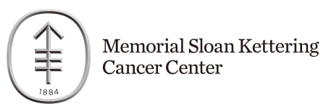

[![Python](https://img.shields.io/pypi/pyversions/tensorflow.svg?style=plastic)](https://badge.fury.io/py/tensorflow)

In [1]:
#----------------------------------------------------------------------------------
# THIS PROGRAM USED FOR GRAD-CAM VISUALIZATION
#----------------------------------------------------------------------------------
#
"""IMPORT ESSENTIAL LIBRARIES"""
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import os.path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#
"""SUPPORTING LIBRARIES"""
import tensorflow as tf
from PIL import Image, ImageOps
#

In [2]:
#
#----------------------------------------------------------------------
# STEP1: INPUT PARAMETERS
#----------------------------------------------------------------------
#
""" Parameters """
hp = {}
hp["csv_path"] = "/mri_triage_normal/input/"       # CSV path
hp["csv_name"] = "sample_test"                     # CSV filename
hp["model_path"] = "/mri_triage_normal/otput/"     # Model path
hp["saved_model"] = "fold1.h5"                     # Pre-trained Model weight
hp["image_size"] = 256                             # image width x height sizing
hp["num_channels"] = 3                             # number of channels fed to network
hp["num_classes"] = 2                              # number of classes in the data set
hp["Normalization"] = "central"                    # Normalization method "simple", "central" and "standard"

In [3]:
""" Functions for reading the data from csv data """
# Step 2(a): Function to read image path, image birads and labels from CSV and create a list
def read_csv(dirpath,filename):
    """READS INTO A DATAFRAME"""
    df = pd.read_csv(os.path.join(dirpath, filename + '.csv'))
    """List all essential parameters to be used later"""
    img_paths = df.File_path.tolist()             # File path
    img_birads = df.BIRADS.tolist()               # BIRADS label
    img_labels = df.Split_class.tolist()          # Pathology label
    #
    return img_paths, img_birads, img_labels
#
# Step 2(b): Function to load the images and true labels
def load_data(imgpaths_temp, imglabels_temp, imglaterlity_temp, dim):
    """Load image
       :param impaths_temp: dummy variable for image path
       :param imglabels_temp: dummy variable for image labels
       :param imglaterlity_temp: dummy variable for image laterity flag
       :dim: dummy variable for output image dimension
       :return: images, labels
    """
    #
    """ Read image """        
    image = Image.open(imgpaths_temp)           # READS 2D MIP
    image = ImageOps.grayscale(image)           # IMAGE TO GRAY SCALE
    image = np.array(image)                     # CONVERTS TO AN ARRAY
    #
    """ Extract Right and Left view """
    w = image.shape[0]
    h = image.shape[1]
    startRX, startRY, endRX, endRY, startLX, startLY, endLX, endLY = int(0), int(0), int(w/2), int(h), int(w/2), int(0), int(w), int(h)
    if imglaterlity_temp == 1:
        image1=np.zeros([endRY-startRY, endRX-startRX])     # Intialize the Crop right image
        image1[:,:] = image[startRY:endRY, startRX:endRX]
    else:
        image1=np.zeros([endLY-startLY, endLX-startLX])     # Intialize the Crop left image
        image1[:,:] = image[startLY:endLY, startLX:endLX]
    #
    """ Resize the image """
    if (image1.shape[0] == hp["image_size"]) and (image1.shape[1] == hp["image_size"]):
        image = image1
    else:
        image = np.array(Image.fromarray(image1).resize((dim[0], dim[1]), Image.ANTIALIAS))
    #
    """ Normalization """
    if hp["Normalization"] == "simple":
        if np.amin(image)<0:
            image = (image - 0) / (np.amax(image) - 0)
        else:
            image = (image - np.amin(image)) / (np.amax(image) - np.amin(image)) 
            # Image normalization from 0.0 to 1.0
        #
    elif hp["Normalization"] == "central":
        if np.amin(image)<0:
            image = (image - np.mean(image)) / (np.amax(image) - 0 + .00000000000000001)
        else:
            image = (image - np.mean(image)) / (np.amax(image) - np.amin(image) + .00000000000000001)
            # Image normalization from -1.0 to 1.0
        #
    elif hp["Normalization"] == "standard":
        image = (image - np.mean(image)) / (np.std(image) + .00000000000000001)
        #
    #
    """ Convert image to 3-Channels """
    image = np.stack((image,)*3, axis=-1) # Shape (w, h, 3)
    image = image.astype("float32")
    image = np.expand_dims(image, axis=0) # Shape to (1, w, h, 3)
    """ True Labels """
    label = tf.keras.utils.to_categorical(imglabels_temp, num_classes=hp["num_classes"], dtype='float32')
    #
    return image, label
#

In [4]:
""" Function for loading the model """
#----------------------------------------------------------------------
# STEP 3: GET THE PRE-TRAINED MODEL
#----------------------------------------------------------------------
def get_model(modelpath, modelweight):
    #
    """ Pre-trained Model path and loading """
    modelpath = os.path.join(modelpath, modelweight)
    model=tf.keras.models.load_model(modelpath)
    #
    return model
#

In [5]:
""" Function to make the GRAD-CAM class activation heatmap"""
#---------------------------------------------------------------------
# STEP 4(A): GET HEATMAP USING GRAD CAM (TO VERIFY MODEL IS FOCUSING
# ON CORRECT IMAGE FEATURE)
#---------------------------------------------------------------------
def compute_heatmap(image, model, conv_layer_name, pred_index):
    #
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the
    # CONV layer in the network, and (3) the output of the
    # softmax activations from the model
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(conv_layer_name).output, model.output])
    #
    # Next, compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        last_conv_layer_output, preds = grad_model(inputs)
        loss = preds[:, pred_index]
    #
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, last_conv_layer_output)
    # compute the guided gradients
    castConvOutputs = tf.cast(last_conv_layer_output > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension at array position 0
    # (we don't need) so let's grab the image without batch parameter
    convOutputs = last_conv_layer_output[0]
    guidedGrads = guidedGrads[0]
    #
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    #
    # Resize the heat map to desired image size (1, h, w, channel) --> (h, w)
    dim = (image.shape[1], image.shape[2])
    heatmap = np.array(Image.fromarray(cam.numpy()).resize((dim[0], dim[1]), Image.ANTIALIAS))
    # Transform the heatmap 0-255 range
    heatmap = (heatmap - np.min(heatmap)) / ((heatmap.max() - heatmap.min()) + 1e-8)
    heatmap = (heatmap * 255).astype("uint8") # Shape (h, w)
    #
    return heatmap
#
#---------------------------------------------------------------------
# STEP 4(B): FUNCTION TO AUTOMATICALLY FIND THE LAST CONV LAYER 
# FOR HEATMAP GENERATION
#---------------------------------------------------------------------
def find_last_layer(model):
    # Attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(model.layers):
        #
        # check to see if the layer has a 4D output because batch and channel
        if len(layer.output_shape) == 4:
            return layer.name
        #
    #
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
#

In [6]:
"""Function to obtain the label score, image and heatmap """
#---------------------------------------------------------------------
# STEP 5: GET PREDICTION SCORE, HEATMAP AND IMAGE
#---------------------------------------------------------------------
def grad_cam_plot(image, model, conv_layer_name):
    probability = model.predict(image, verbose=0) # Identify the probability
    pred_index = np.argmax(probability)  # Predicted labeles (i.e., maximum either 0 or 1)
    score=probability[0][1]              # Score for probability of being 
                                         # possibly suspicion for each exam
    heatmap = compute_heatmap(image, model, conv_layer_name, pred_index)
    image = np.squeeze(image, axis=0)    # remove the batch term shape (h, w, channel)
    #
    return score, image, heatmap
#

In [7]:
"""Function to join the right and left breast image and heatmap together"""
#---------------------------------------------------------------------
# STEP 6: COMBINE RIGHT AND LEFT SIDE OF BREAST (USED IN PLOTTING)
#---------------------------------------------------------------------
def concat_images(imga, imgb):
    """
    Combines two color image right+left breast side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb # shape (h, w, 3)
    return new_img
#
def concat_heatmap(imga, imgb):
    """
    Combines two heatmap right+left breast side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb  # shape (h, w)
    return new_img
#

### **MAIN PLOTTING CODE USES ABOVE FUNCTIONS**

/tmp/ipykernel_3099150/524989911.py:45: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = np.array(Image.fromarray(image1).resize((dim[0], dim[1]), Image.ANTIALIAS))
/tmp/ipykernel_3099150/22350097.py:40: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap = np.array(Image.fromarray(cam.numpy()).resize((dim[0], dim[1]), Image.ANTIALIAS))
/tmp/ipykernel_3099150/3411754202.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  combined_image = np.array(Image.fromarray(combined_image[:,:,0]).resize((dim[0], dim[1]), Image.ANTIALIAS))
/tmp/ipykernel_3099150/3411754202.py:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  combined_hea

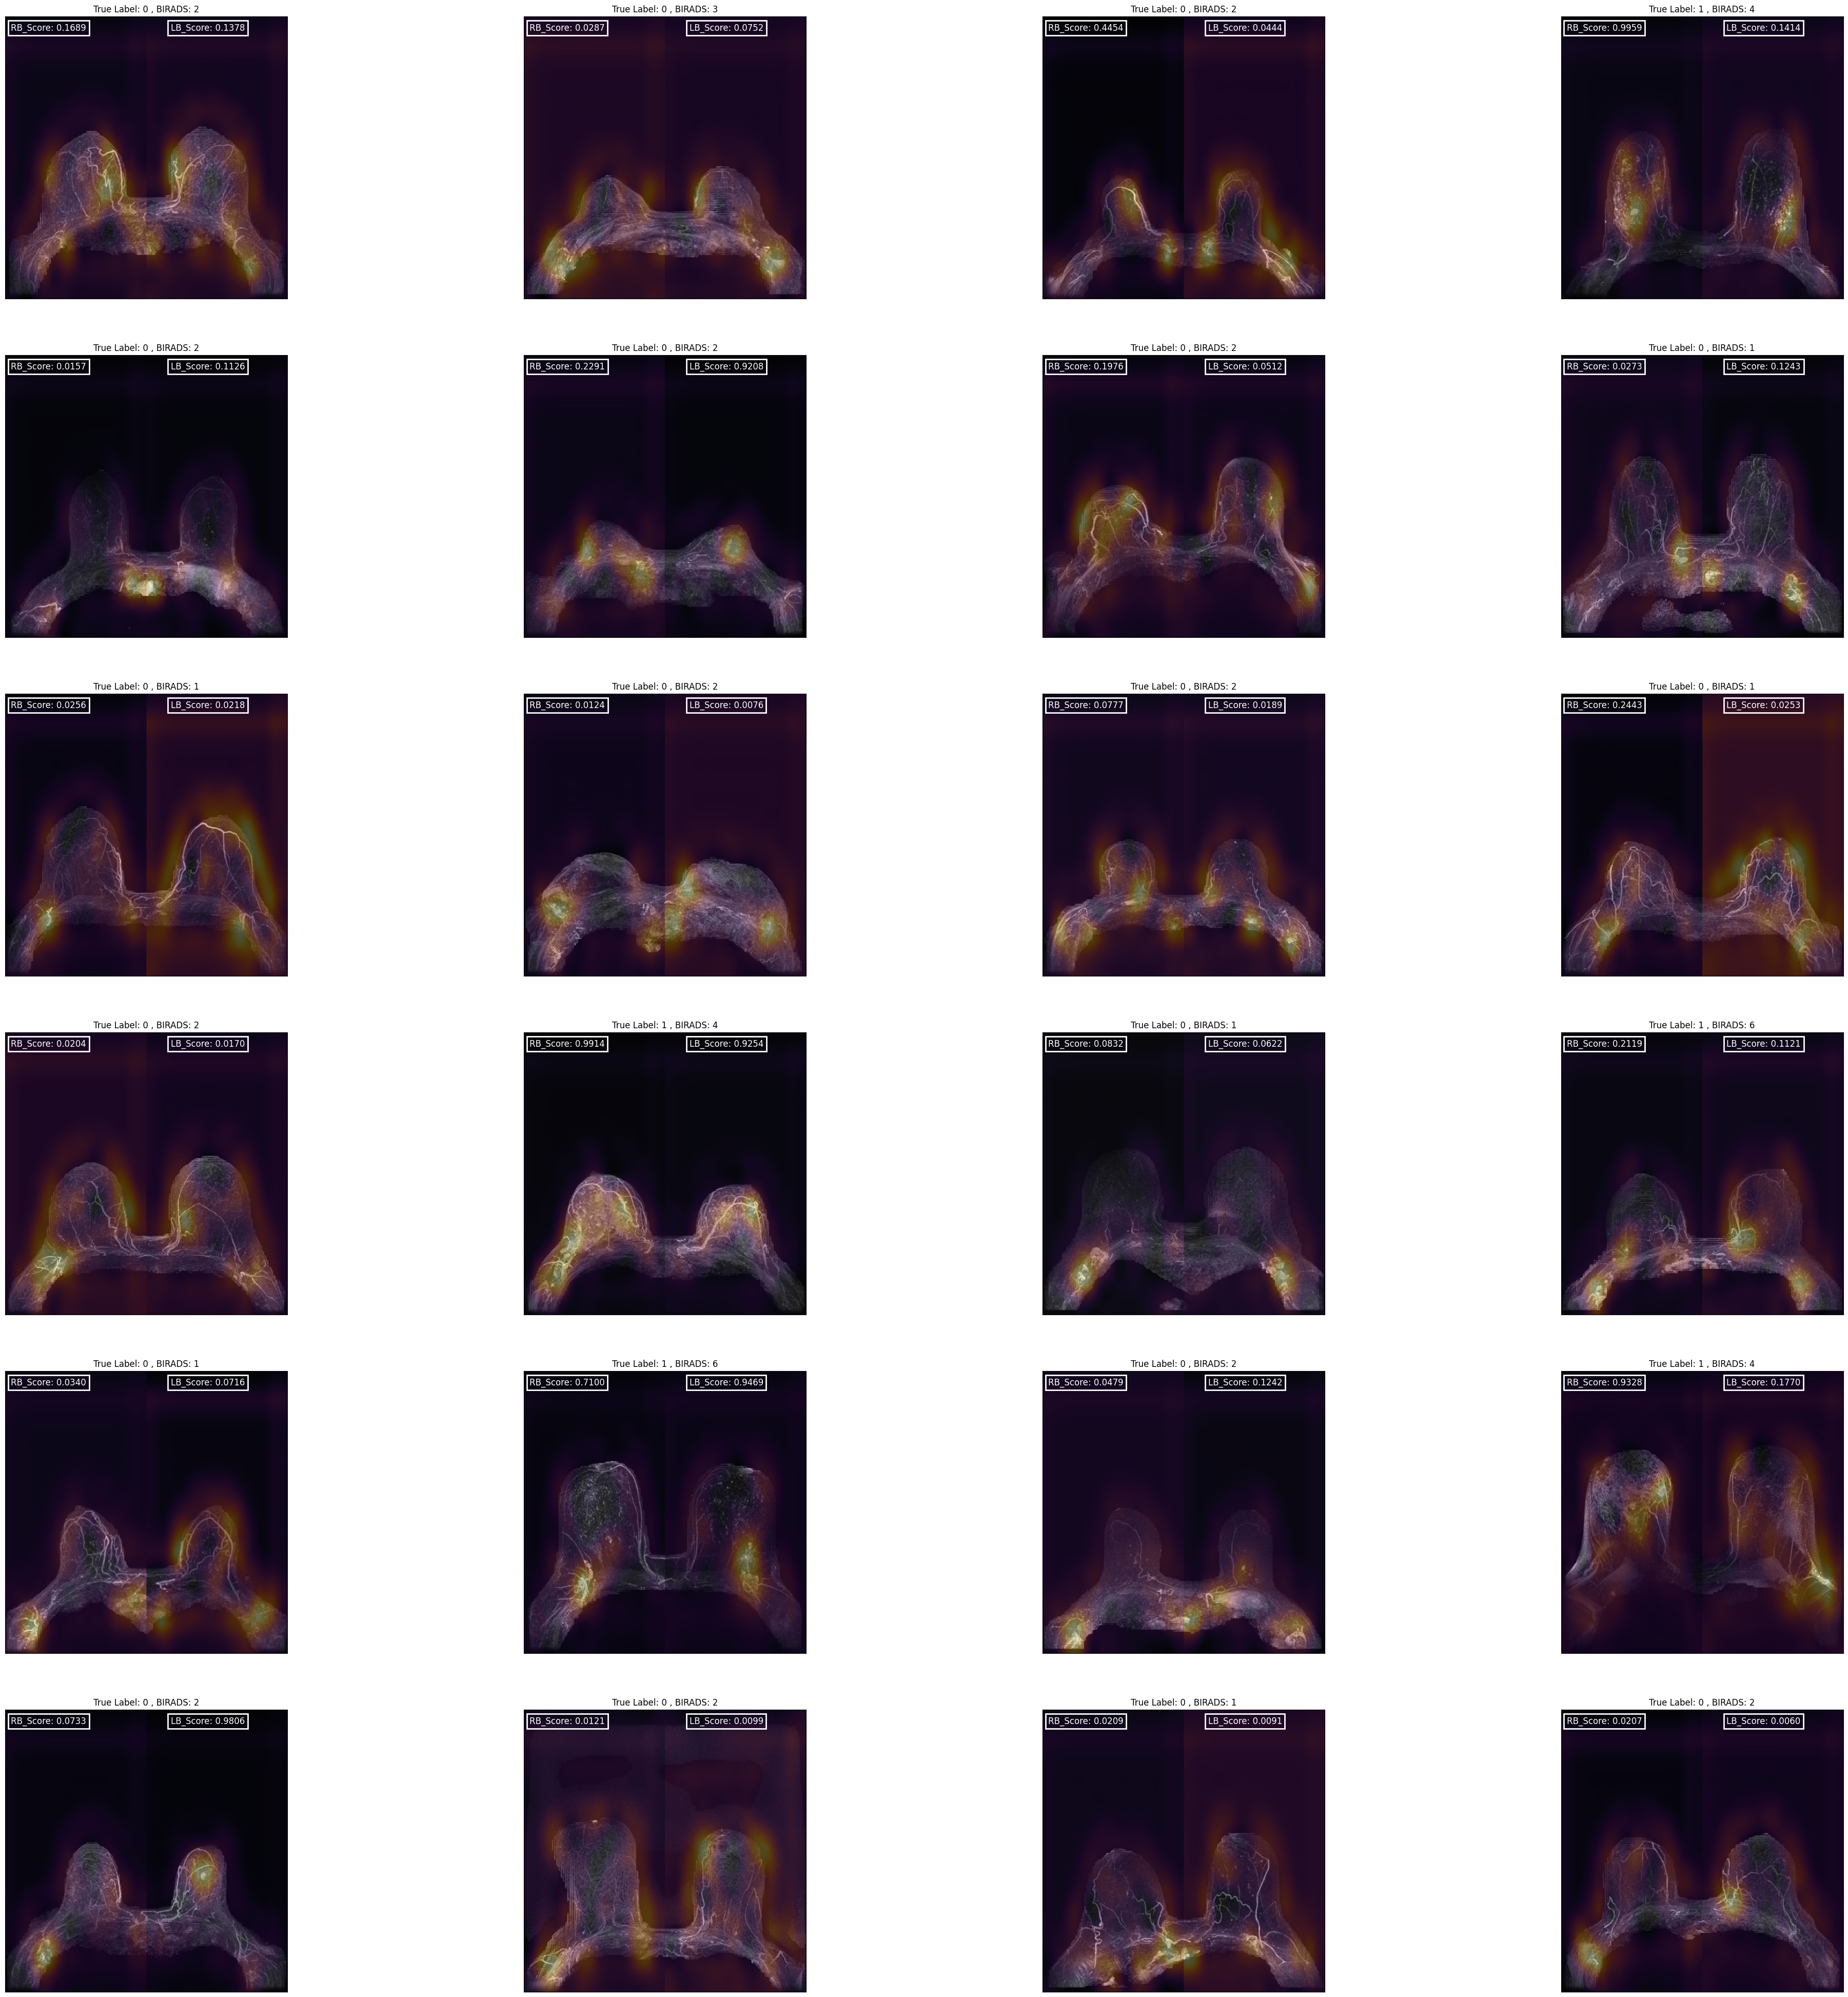

In [8]:
#---------------------------------------------------------------------
# STEP 7: PLOT THE OVERLAP GRAD CAM IMAGE
#---------------------------------------------------------------------
img_paths, img_birads, img_labels = read_csv(hp["csv_path"],hp["csv_name"])  # Reads the csv
dim = (hp["image_size"], hp["image_size"]) # Array definining the image shape
""" Load the model """
model = get_model(hp["model_path"], hp["saved_model"])
#
"""Automatically determine the last 4D/CONV layer"""
conv_layer_name = find_last_layer(model)
# One can also identify their desired conv layer using "model.summary()" command and specify the conv layer
# conv_layer_name = "block5_conv3"
#
"""Plot the images """
plt.figure(figsize=(50, 50));
column = 4  # subplot column
row = 6  # subplot row
product = row*column
for jdx in range(0,product):
    idx = jdx
    # idx = 1*product+jdx
    #
    # Right side flag = 1
    image_R, label_R = load_data(img_paths[idx], img_labels[idx], 1, dim)
    score_R, image_R, heatmap_R = grad_cam_plot(image_R, model, conv_layer_name)
    # Left side flag = 2
    image_L, label_L = load_data(img_paths[idx], img_labels[idx], 2, dim)
    score_L, image_L, heatmap_L = grad_cam_plot(image_L, model, conv_layer_name)
    # Combined Right and Left images
    combined_image = concat_images(image_R, image_L)
    combined_image = np.array(Image.fromarray(combined_image[:,:,0]).resize((dim[0], dim[1]), Image.ANTIALIAS))
    # Combined Right and Left heatmaps
    combined_heatmap = concat_heatmap(heatmap_R, heatmap_L)
    combined_heatmap = np.array(Image.fromarray(combined_heatmap).resize((dim[0], dim[1]), Image.ANTIALIAS))
    #
    plt.subplot(row,column,jdx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(combined_image, cmap=plt.cm.gray);
    plt.imshow(combined_heatmap, cmap=plt.cm.inferno, alpha=.3);
    plt.text(10, 25, "{}: {:.4f}".format('RB_Score', (score_R)), color='white', fontsize=12, bbox=dict(fill=False, edgecolor='white', linewidth=2));
    plt.text(300, 25, "{}: {:.4f}".format('LB_Score', (score_L)), color='white', fontsize=12, bbox=dict(fill=False, edgecolor='white', linewidth=2));
    plt.title("{}: {} {}: {}".format('True Label', (img_labels[idx]), ', BIRADS', (img_birads[idx])), fontweight=10, loc='center');
#

End of Program